# Análise de Enchentes - Rio

Este notebook analisa dados meteorológicos para identificar gatilhos de alertas de inundação utilizando aprendizado de máquina. O conjunto de dados é proveniente de um banco de dados SQLite (`dados_meteorologicos.db`) com dados meteorológicos horários. O objetivo é pré-processar os dados, realizar análise exploratória, engenhar variáveis e treinar um modelo para prever o risco de inundação. O mecanismo de alerta será delineado para futura integração com um sistema de mensagens.

## 1. Importar Bibliotecas

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8')

## 2. Carregar dados de uma base SQLite

In [2]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('assets/dados_meteorologicos.db')

# Query all data from dados_horarios table
query = "SELECT * FROM dados_horarios"
df = pd.read_sql_query(query, conn, parse_dates=['date'])

# Close the connection
conn.close()

# Display first few rows
print(df.head())

                       date  temperature_2m  wind_speed_10m  \
0 2024-02-01 03:00:00+00:00       20.032000        1.019804   
1 2024-02-01 04:00:00+00:00       19.532000        0.728011   
2 2024-02-01 05:00:00+00:00       18.882000        0.848528   
3 2024-02-01 06:00:00+00:00       18.231998        0.721110   
4 2024-02-01 07:00:00+00:00       18.081999        0.412311   

   wind_direction_10m  wind_gusts_10m  soil_temperature_0cm  \
0          168.690109             2.0             19.231998   
1          195.945465             1.7             17.981998   
2          224.999893             1.0             16.681999   
3          236.309906             1.0             16.282000   
4          255.963730             0.7             16.081999   

   soil_moisture_0_to_1cm  soil_moisture_1_to_3cm  soil_temperature_6cm  \
0                   0.083                   0.106             22.831999   
1                   0.086                   0.106             22.282000   
2                

## 3. Processamento dos dados

In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Fill missing values (e.g., forward fill for time-series continuity)
df = df.fillna(method='ffill')

# Convert date to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Create a synthetic target variable for flood risk
# Assumption: High precipitation (>5mm) and high soil moisture (>0.35) indicate flood risk
df['flood_risk'] = ((df['precipitation'] > 5) & (df['soil_moisture_0_to_1cm'] > 0.35)).astype(int)


# Display target variable distribution
print("Flood risk distribution:")
print(df['flood_risk'].value_counts())

Missing values per column:
date                        0
temperature_2m              0
wind_speed_10m              0
wind_direction_10m          0
wind_gusts_10m              0
soil_temperature_0cm        0
soil_moisture_0_to_1cm      0
soil_moisture_1_to_3cm      0
soil_temperature_6cm        0
wind_speed_80m              0
precipitation               0
relative_humidity_2m        0
cloud_cover                 0
cloud_cover_low             0
cloud_cover_mid             0
cloud_cover_high            0
surface_pressure            0
wind_direction_80m          0
wind_direction_120m         0
wind_direction_180m         0
wind_speed_180m             0
wind_speed_120m             0
temperature_80m             0
temperature_120m            0
temperature_180m            0
soil_temperature_18cm       0
soil_temperature_54cm       0
soil_moisture_3_to_9cm      0
soil_moisture_9_to_27cm     0
soil_moisture_27_to_81cm    0
dtype: int64
Flood risk distribution:
flood_risk
0    3598
1      26
Name

C:\Users\user\AppData\Local\Temp\ipykernel_9600\1363602483.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


## 4. Analise Exploratória dos dados

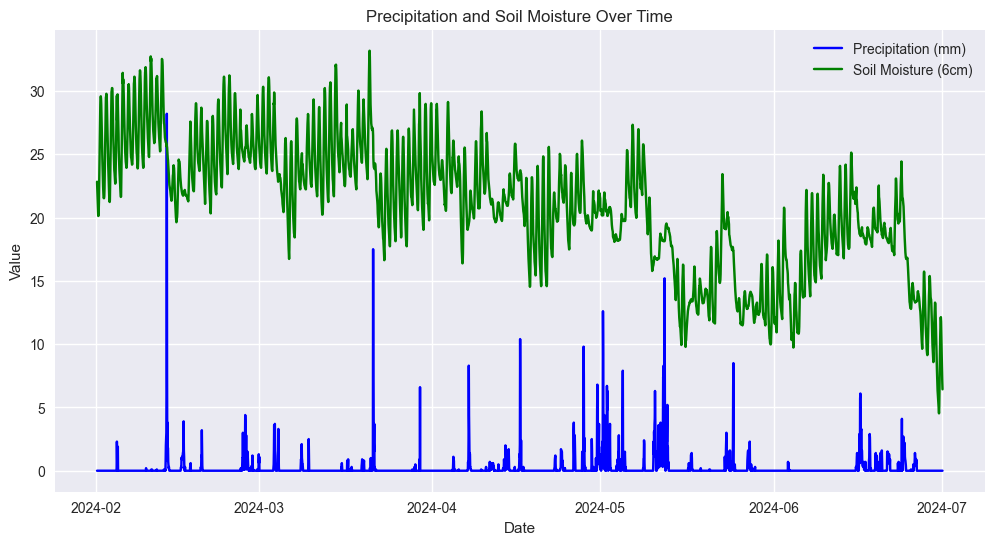

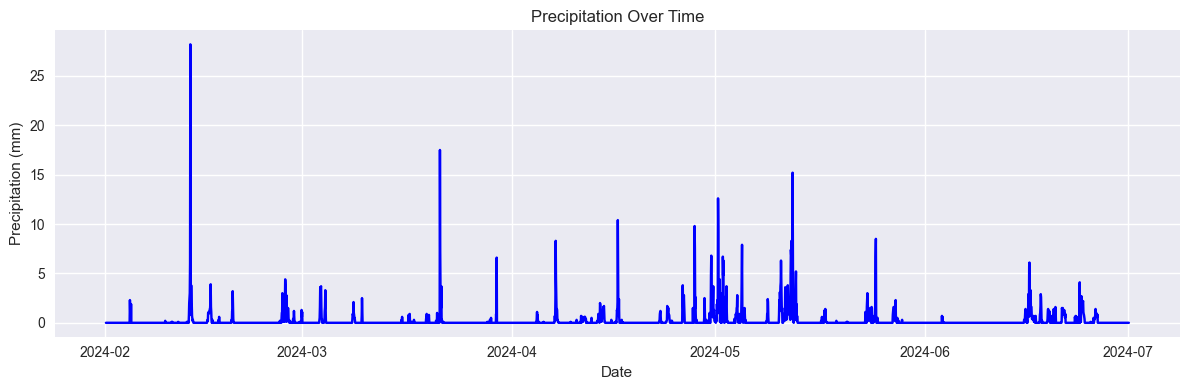

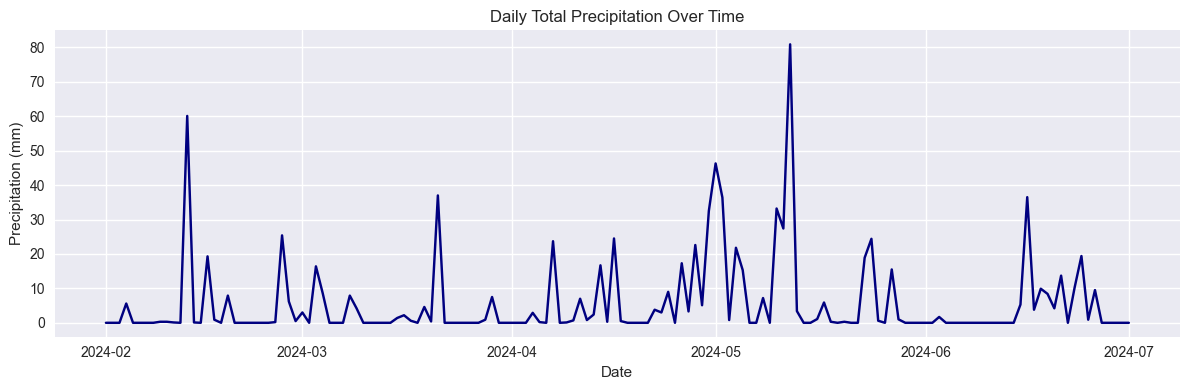

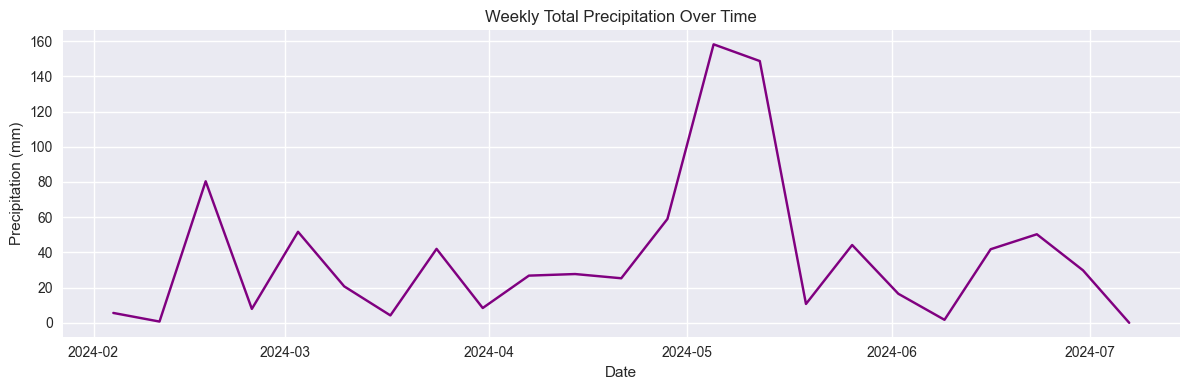

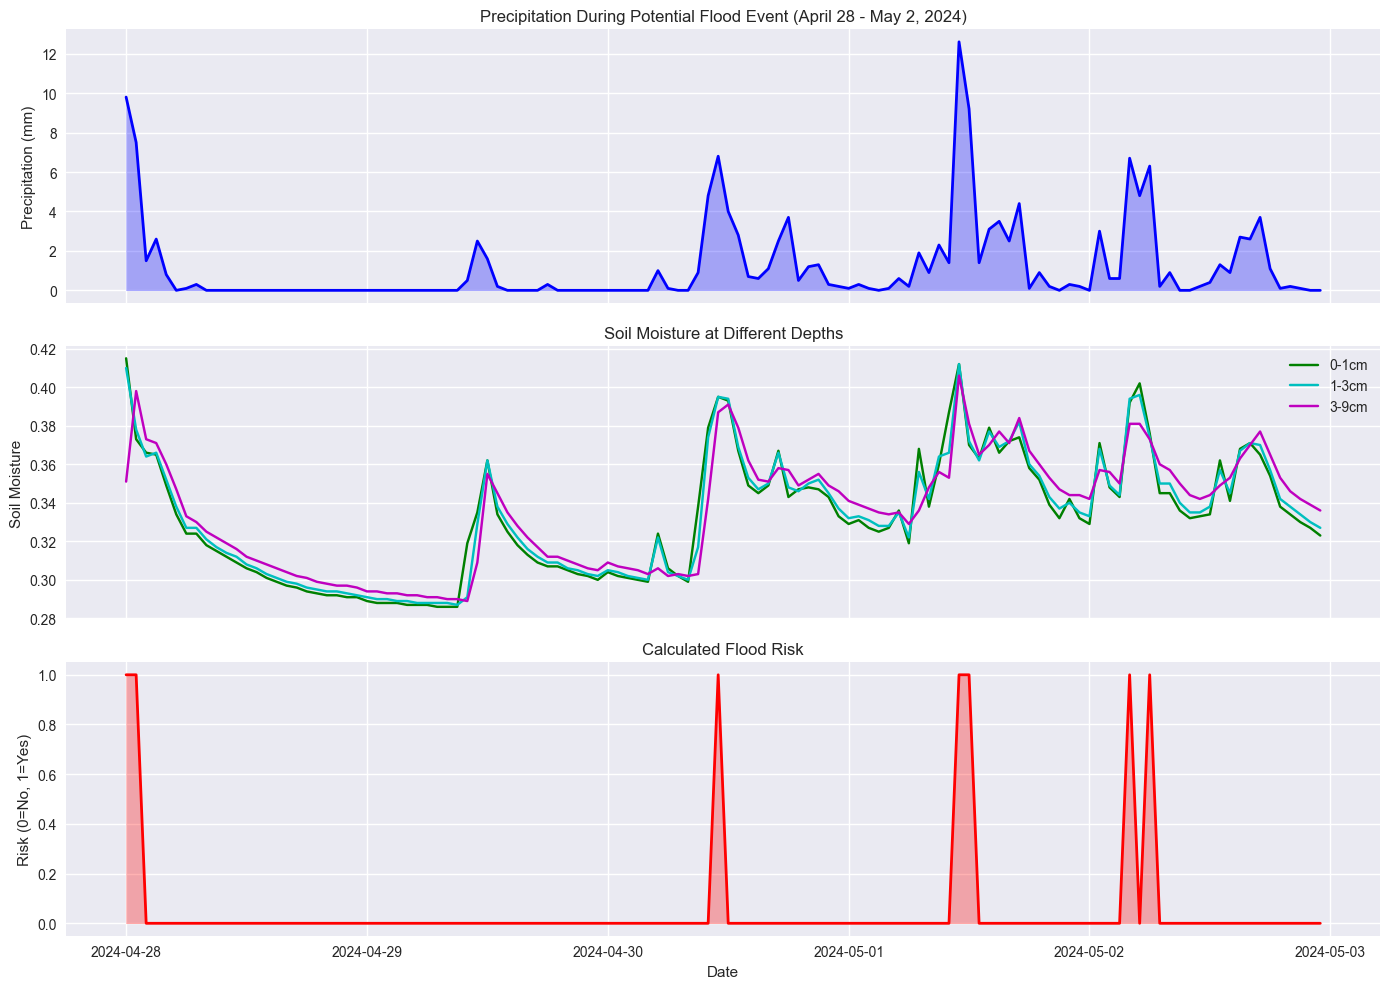

C:\Users\user\AppData\Local\Temp\ipykernel_9600\2332995217.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_period['cumulative_precipitation'] = flood_period['precipitation'].cumsum()


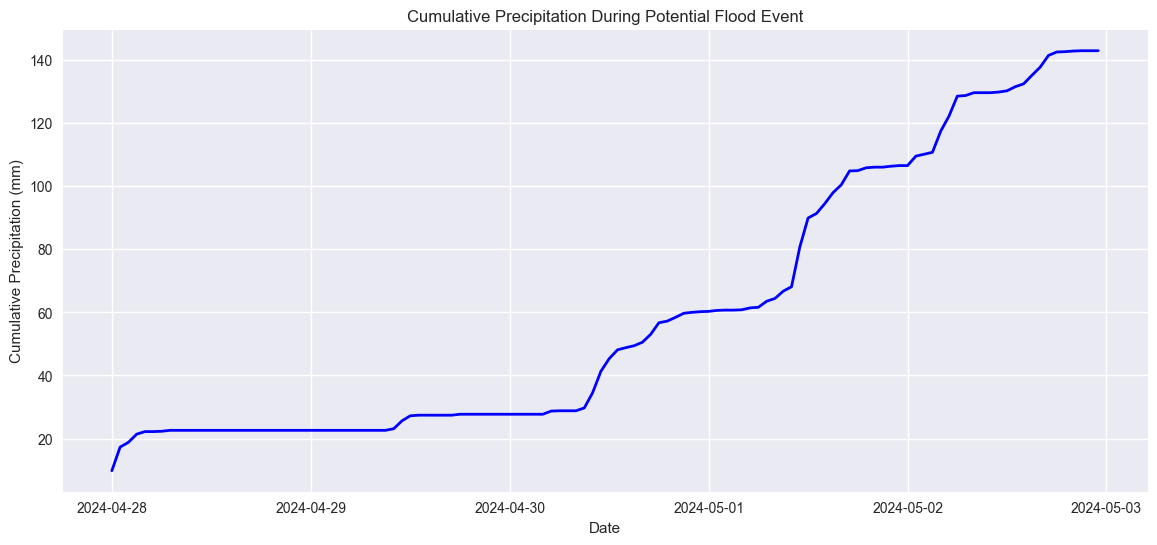

Statistical summary of key variables during potential flood period:
       precipitation  soil_moisture_0_to_1cm  soil_moisture_1_to_3cm  \
count     120.000000              120.000000              120.000000   
mean        1.190833                0.332400                0.333375   
std         2.202786                0.031385                0.030775   
min         0.000000                0.286000                0.287000   
25%         0.000000                0.304000                0.304750   
50%         0.200000                0.332000                0.334500   
75%         1.300000                0.352500                0.354500   
max        12.600000                0.415000                0.412000   

       relative_humidity_2m  
count            120.000000  
mean              94.083333  
std                4.450632  
min               83.000000  
25%               91.000000  
50%               96.000000  
75%               98.000000  
max               99.000000  

Correlation 

In [10]:
# Plot precipitation and soil moisture over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['precipitation'], label='Precipitation (mm)', color='blue')
plt.plot(df.index, df['soil_temperature_6cm'], label='Soil Moisture (6cm)', color='green')
plt.title('Precipitation and Soil Moisture Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['precipitation'], color='blue')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()
plt.show()

# Plot daily total precipitation over time
daily_precip = df['precipitation'].resample('D').sum()
plt.figure(figsize=(12, 4))
plt.plot(daily_precip.index, daily_precip.values, color='navy')
plt.title('Daily Total Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()
plt.show()

# Plot weekly total precipitation over time
weekly_precip = df['precipitation'].resample('W').sum()
plt.figure(figsize=(12, 4))
plt.plot(weekly_precip.index, weekly_precip.values, color='purple')
plt.title('Weekly Total Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()
plt.show()

# Create a focused analysis on potential flood period
flood_period = df.loc['2024-04-28':'2024-05-02']

# Plot key variables during flood period
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Precipitation
axes[0].plot(flood_period.index, flood_period['precipitation'], 'b-', linewidth=2)
axes[0].set_title('Precipitation During Potential Flood Event (April 28 - May 2, 2024)')
axes[0].set_ylabel('Precipitation (mm)')
axes[0].fill_between(flood_period.index, flood_period['precipitation'], alpha=0.3, color='blue')
axes[0].grid(True)

# Soil moisture at different levels
axes[1].plot(flood_period.index, flood_period['soil_moisture_0_to_1cm'], 'g-', label='0-1cm')
axes[1].plot(flood_period.index, flood_period['soil_moisture_1_to_3cm'], 'c-', label='1-3cm')
axes[1].plot(flood_period.index, flood_period['soil_moisture_3_to_9cm'], 'm-', label='3-9cm')
axes[1].set_title('Soil Moisture at Different Depths')
axes[1].set_ylabel('Soil Moisture')
axes[1].legend()
axes[1].grid(True)

# Flood risk (highlighting risky periods)
axes[2].plot(flood_period.index, flood_period['flood_risk'], 'r-', linewidth=2)
axes[2].set_title('Calculated Flood Risk')
axes[2].set_ylabel('Risk (0=No, 1=Yes)')
axes[2].set_xlabel('Date')
axes[2].fill_between(flood_period.index, flood_period['flood_risk'], alpha=0.3, color='red')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Calculate cumulative precipitation for the period
flood_period['cumulative_precipitation'] = flood_period['precipitation'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(flood_period.index, flood_period['cumulative_precipitation'], 'b-', linewidth=2)
plt.title('Cumulative Precipitation During Potential Flood Event')
plt.ylabel('Cumulative Precipitation (mm)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Show summary statistics for the flood period
print("Statistical summary of key variables during potential flood period:")
print(flood_period[['precipitation', 'soil_moisture_0_to_1cm', 
                    'soil_moisture_1_to_3cm', 'relative_humidity_2m']].describe())

# Check correlation during the flood period
print("\nCorrelation between variables during potential flood period:")
correlation = flood_period[features + ['flood_risk']].corr()
print(correlation['flood_risk'].sort_values(ascending=False))

## 5. Feature Engineering

In [5]:
# Select relevant features for the model
features = [
    'precipitation', 'soil_moisture_0_to_1cm', 'soil_moisture_1_to_3cm',
    'relative_humidity_2m', 'surface_pressure', 'cloud_cover'
]

# Create feature matrix X and target y
X = df[features]
y = df['flood_risk']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## 6. Treinar Um modelo 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       720
           1       1.00      1.00      1.00         5

    accuracy                           1.00       725
   macro avg       1.00      1.00      1.00       725
weighted avg       1.00      1.00      1.00       725



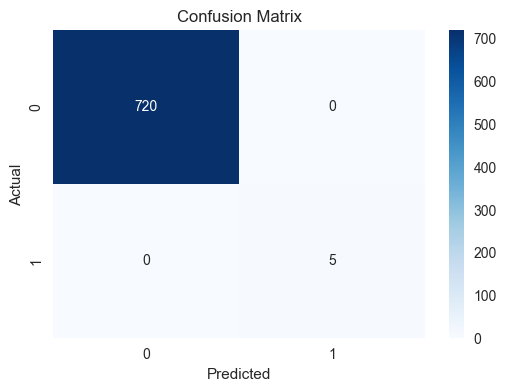

In [6]:
# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7. Importancia das Features

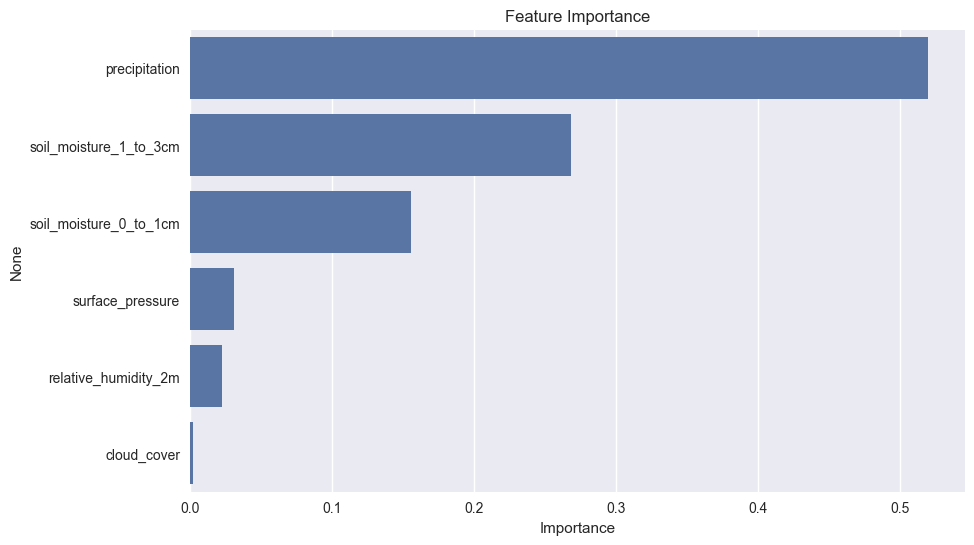

In [7]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

## 8. Outline for Alert System

To generate flood alerts via messaging, you can:
1. Use the trained model to predict flood risk on new data.
2. Set a threshold (e.g., probability > 0.7) for issuing alerts.
3. Integrate with a messaging service (e.g., Twilio, Telegram API, or email SMTP).

Example pseudocode for alert generation:
```python
def send_alert(data_point, model, scaler, threshold=0.7):
    # Preprocess new data
    data_scaled = scaler.transform(data_point[features])
    # Predict flood risk
    prob = model.predict_proba(data_scaled)[:, 1]
    if prob > threshold:
        # Send alert (e.g., via messaging service)
        print(f"Flood Alert! Probability: {prob[0]:.2f}")
        # Add messaging service code here (e.g., Twilio or Telegram)
    return prob
```

You can extend this by integrating a messaging library and scheduling the script to run hourly.

In [8]:
# Display current threshold values and feature statistics
print("Alert thresholds:")
print(f"- Precipitation > {precipitation_threshold} mm")
print(f"- Soil moisture (0-1cm) > {soil_moisture_threshold}")
print(f"- Model probability > {model_alert_threshold}")

print("\nFeature statistics (min, mean, max):")
for feature in features:
    vals = df[feature]
    print(f"{feature}: min={vals.min():.3f}, mean={vals.mean():.3f}, max={vals.max():.3f}")




Alert thresholds:


NameError: name 'precipitation_threshold' is not defined

## 9. Next Steps

- Refine the target variable using actual flood event data if available.
- Experiment with other models (e.g., XGBoost, LSTM for time-series).
- Implement the messaging system for real-time alerts.
- Validate the model with cross-validation and hyperparameter tuning.